# 2022378 AI Project

### Import dependencies

In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
train = pd.read_csv('/content/sampled_file.csv')
test = pd.read_csv('/content/test.csv')

A sneak peek at the training and testing dataset

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,9b740c6c50e2a39e,Probably a lonnnnnnng time.,0,0,0,0,0,0
1,a81a39a77242201f,Bosh and Wade are BOTH listed as SIGNED to the...,0,0,0,0,0,0
2,11d94246384428b1,|unblock|2=reason=''Your reason here: I was un...,0,0,0,0,0,0
3,6bbebed8196b1418,"Added the advert template, tried to add it to ...",0,0,0,0,0,0
4,34ba3efe8abc82b9,(UTC)\r\n \r\nI have friends at What Now who h...,0,0,0,0,0,0


In [ ]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool)

# Let's do some data cleaning here

In [ ]:
nltk.download('wordnet')

In [ ]:
import re
import nltk
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

snowball_stemmer = SnowballStemmer('english')
#porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
def dataCleaning(txt):
    CleanData = re.sub('https\S+\s', ' ', txt)  #Cleaning links via re
    CleanData = re.sub(r'\d', ' ', CleanData)   #Cleaning numbers via re
    CleanData = re.sub('@\S+', ' ', CleanData)  #Cleaning email address via re
    CleanData = re.sub('#\S+\s', ' ', CleanData)    #Cleaning # symbol via re
    CleanData = re.sub(r'"', '', CleanData)  # Remove inverted commas via re
    CleanData = re.sub('[^a-zA-Z0-9]', ' ', CleanData)  #Cleaning special characters via re
    CleanData = remove_stopwords(CleanData) #Cleaning stopwords via genism
    CleanData = CleanData.lower()  # Convert to lowercase
    CleanData = snowball_stemmer.stem(CleanData)
    #CleanData = porter_stemmer.stem(CleanData)  #Stemming via nltk
    CleanData = lemmatizer.lemmatize(CleanData) #Lemmatization via nltk
    return CleanData

In [ ]:
train['comment_text'] = train['comment_text'].apply(lambda x : dataCleaning(x))

In [ ]:
test['comment_text'] = test['comment_text'].apply(lambda x : dataCleaning(x))

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

The approach that we are taking is to feed the comments into the LSTM as partof the neural network but we can't just feed the words as it is.
So this is what we are going to do:

Tokenization - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]

Indexing - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}

Index Representation- We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. For eg, [1,2,3,4,2,5]

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [ ]:
list_tokenized_train[:1]

[[290, 6, 84]]

In [ ]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

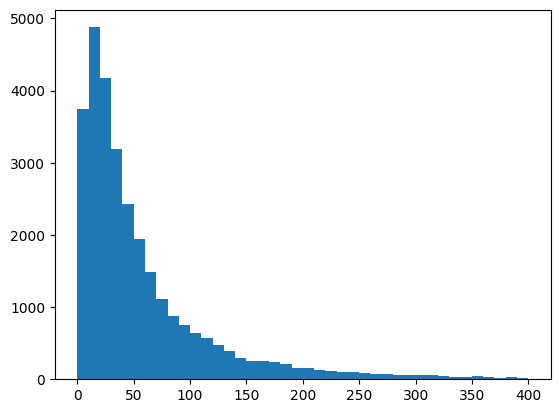

In [ ]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

As we can see, most of the sentence length is about 30+. We could set the "maxlen" to about 50, but I'm being paranoid so I have set to 200. Then again, it sounds like something you could experiment and see what is the magic number.

In [ ]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

Finally the start of building our model!

In [ ]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

We are almost done! All is left is to define the inputs, outputs and configure the learning process. We have set our model to optimize our loss function using Adam optimizer, define the loss function to be "binary_crossentropy" since we are tackling a binary classification. In case you are looking for the learning rate, the default is set at 0.001.

In [ ]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

The moment that we have been waiting for as arrived! It's finally time to put our model to the test. We'll feed in a list of 32 padded, indexed sentence for each batch and split 10% of the data as a validation set. This validation set will be used to assess whether the model has overfitted, for each batch. The model will also run for 2 epochs. These are some of the tunable parameters that you can experiment with, to see if you can push the accurate to the next level without crashing your machine(hence the batch size)

In [ ]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
844/844 [==============================] - 53s 55ms/step - loss: 0.1392 - accuracy: 0.7851 - val_loss: 0.0611 - val_accuracy: 0.9947
Epoch 2/2
844/844 [==============================] - 17s 20ms/step - loss: 0.0559 - accuracy: 0.9729 - val_loss: 0.0538 - val_accuracy: 0.9947


In this code we have make a function to test our model and the results are displayed below in terms of probability of the label likely to be present in the sentence.

In [ ]:
import numpy as np

# Assuming 'model' is your trained model and 'tokenizer' is the tokenizer used for training

# New text data
new_text = ['''
Guys I'm fucking bored give me something to do
''']

# Data cleaning
new_text = new_text.apply(lambda x : dataCleaning(x))
# Tokenize and pad the new text data
new_tokenized = tokenizer.texts_to_sequences(new_text)
new_padded = pad_sequences(new_tokenized, maxlen=maxlen)

# Make predictions
predictions = model.predict(new_padded)

# Convert probabilities to binary labels
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Print binary predictions
print(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
print(predictions)

1/1 [==============================] - 0s 53ms/step
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
[[0.9836505  0.27722102 0.89998245 0.04780458 0.8597599  0.1199179 ]]


In [ ]:
test[list_classes]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
7995,0,0,0,0,0,0
7996,1,0,0,0,1,1
7997,0,0,0,0,0,0
7998,1,0,0,0,0,0
